### Data preparation

In [133]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [134]:
import matplotlib.pyplot as plt 

In [135]:
df = pd.read_csv("train.csv")

In [136]:
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


#### Basic visual inspection of data

In [137]:
df.shape

(233154, 41)

In [138]:
df.dtypes

UniqueID                                 int64
disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
branch_id                                int64
supplier_id                              int64
manufacturer_id                          int64
Current_pincode_ID                       int64
Date.of.Birth                           object
Employment.Type                         object
DisbursalDate                           object
State_ID                                 int64
Employee_code_ID                         int64
MobileNo_Avl_Flag                        int64
Aadhar_flag                              int64
PAN_flag                                 int64
VoterID_flag                             int64
Driving_flag                             int64
Passport_flag                            int64
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION           object
PRI.NO.OF.ACC

In [139]:
df.isna().sum()

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

There is no other correlated attribute from which we could impute missing values so we drop them.

In [140]:
df.dropna(inplace=True)

Dropped customer id because its unique,pincode is randomly chosen by a customer. Since PERFORM_CNS.SCORE and PERFORM_CNS.SCORE.DESCRIPTION are correlated(there is a range from which we can determine class that it belongs to) we drop it .

In [141]:
df.drop(columns=["UniqueID","Current_pincode_ID","PERFORM_CNS.SCORE","DisbursalDate"],inplace=True)

Data set is really imbalanced

In [142]:
df["loan_default"].value_counts(normalize="index")

0    0.782845
1    0.217155
Name: loan_default, dtype: float64

#### Correlations

In [143]:
import seaborn as sns

<AxesSubplot:>

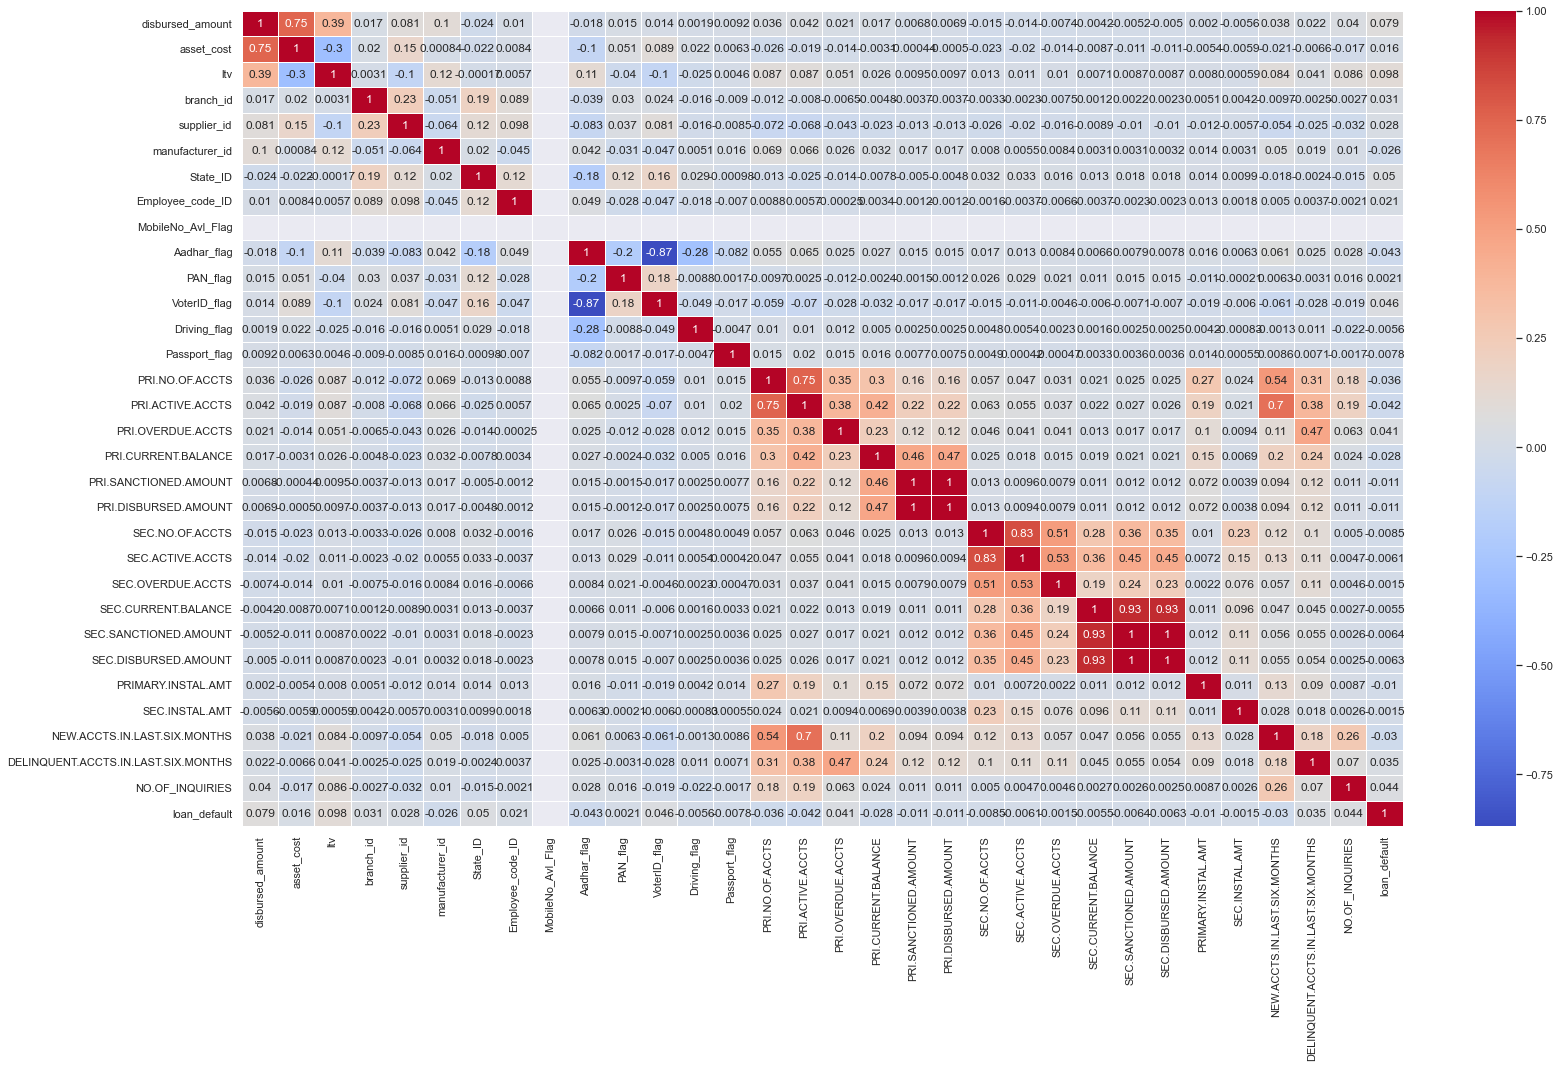

In [144]:
sns.set_theme()
plt.figure(figsize=(26, 15))
sns.heatmap(df.select_dtypes(include=["int64","float64"]).corr(),cmap="coolwarm",annot=True,linewidths=.5)

In [145]:
df["MobileNo_Avl_Flag"].nunique()

1

- Sanctioned amount and disbursed amount are perfectly correlated.Secondary account current balance is almost perfectly correlated with sanctioned amount and disbursed amount.So we drop both attributes.
- Active accounts(primary and secondary) are highly correlated with number of accounts.
- Voter Id is also highly correlated with aadhar so we dropped it.
- Same thing applies for asset cost.
- Mobile flag whole column is filled with 1 so we drop it.

In [146]:
df.drop(columns=["PRI.SANCTIONED.AMOUNT","SEC.SANCTIONED.AMOUNT","SEC.DISBURSED.AMOUNT","SEC.ACTIVE.ACCTS","PRI.ACTIVE.ACCTS","VoterID_flag","asset_cost","MobileNo_Avl_Flag"],inplace=True)

In [147]:
df.shape

(225493, 29)

#### Categorical data preparation

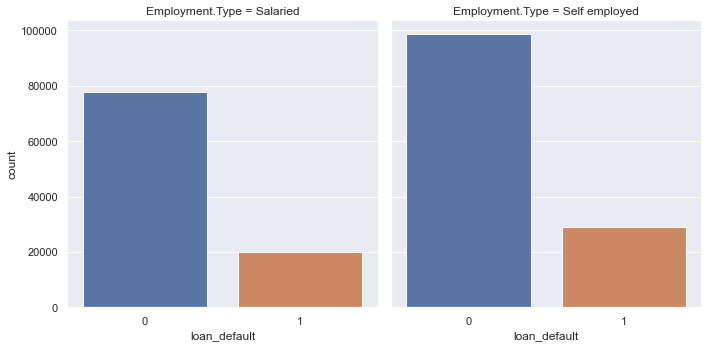

In [148]:
sns.catplot(x = 'loan_default', col = 'Employment.Type', data = df, kind = 'count')

We can see that this attribute has impact on the output variable

In [149]:
pd.crosstab(df['loan_default'], df['Employment.Type'], normalize = 'index')

Employment.Type,Salaried,Self employed
loan_default,,
0,0.441567,0.558433
1,0.406600,0.593400


Converting years to months

In [150]:
split = df["AVERAGE.ACCT.AGE"].str.split(" ",expand=True)
df["AVERAGE.ACCT.AGE"] = split[0].str.split("yrs",expand=True)[0].astype("int64")*12 + split[1].str.split("mon",expand=True)[0].astype("int64")

In [151]:
df["AVERAGE.ACCT.AGE"].describe()

count    225493.000000
mean          9.028302
std          15.161620
min           0.000000
25%           0.000000
50%           0.000000
75%          13.000000
max         369.000000
Name: AVERAGE.ACCT.AGE, dtype: float64

In [152]:
split = df["CREDIT.HISTORY.LENGTH"].str.split(" ",expand=True)
df["CREDIT.HISTORY.LENGTH"] = split[0].str.split("yrs",expand=True)[0].astype("int64")*12 + split[1].str.split("mon",expand=True)[0].astype("int64")

In [153]:
df["CREDIT.HISTORY.LENGTH"].describe()

count    225493.000000
mean         16.453087
std          28.676869
min           0.000000
25%           0.000000
50%           0.000000
75%          24.000000
max         468.000000
Name: CREDIT.HISTORY.LENGTH, dtype: float64

Extracting years from date of birth

In [154]:
split = df["Date.of.Birth"].str.split("-",expand=True)
df["Date.of.Birth"] = 122-split[2].astype("int64")

In [155]:
df["Date.of.Birth"].describe()

count    225493.000000
mean         38.448009
std           9.666254
min          24.000000
25%          30.000000
50%          37.000000
75%          45.000000
max          68.000000
Name: Date.of.Birth, dtype: float64

In [156]:
df["Date.of.Birth"].head()

0    38
1    37
2    37
3    29
4    45
Name: Date.of.Birth, dtype: int64

In [157]:
df.select_dtypes(include="int64").nunique()

disbursed_amount                       24228
branch_id                                 82
supplier_id                             2945
manufacturer_id                           11
Date.of.Birth                             45
State_ID                                  22
Employee_code_ID                        3269
Aadhar_flag                                2
PAN_flag                                   2
Driving_flag                               2
Passport_flag                              2
PRI.NO.OF.ACCTS                          107
PRI.OVERDUE.ACCTS                         22
PRI.CURRENT.BALANCE                    70044
PRI.DISBURSED.AMOUNT                   47206
SEC.NO.OF.ACCTS                           37
SEC.OVERDUE.ACCTS                          9
SEC.CURRENT.BALANCE                     3197
PRIMARY.INSTAL.AMT                     27608
SEC.INSTAL.AMT                          1890
NEW.ACCTS.IN.LAST.SIX.MONTHS              26
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS       14
AVERAGE.AC

In [158]:
df['loan_default'] = df['loan_default'].map({0: 'No', 1: 'Yes'})

Converting ID attributes to object

In [159]:
df[["branch_id","supplier_id","manufacturer_id","Employee_code_ID","State_ID"]]= df[["branch_id","supplier_id","manufacturer_id","Employee_code_ID","State_ID"]].astype("object")

In [160]:
df.dtypes

disbursed_amount                         int64
ltv                                    float64
branch_id                               object
supplier_id                             object
manufacturer_id                         object
Date.of.Birth                            int64
Employment.Type                         object
State_ID                                object
Employee_code_ID                        object
Aadhar_flag                              int64
PAN_flag                                 int64
Driving_flag                             int64
Passport_flag                            int64
PERFORM_CNS.SCORE.DESCRIPTION           object
PRI.NO.OF.ACCTS                          int64
PRI.OVERDUE.ACCTS                        int64
PRI.CURRENT.BALANCE                      int64
PRI.DISBURSED.AMOUNT                     int64
SEC.NO.OF.ACCTS                          int64
SEC.OVERDUE.ACCTS                        int64
SEC.CURRENT.BALANCE                      int64
PRIMARY.INSTA

#### Numerical Preparation

In [161]:
len(df.select_dtypes(["int64","float64"]).columns)

21

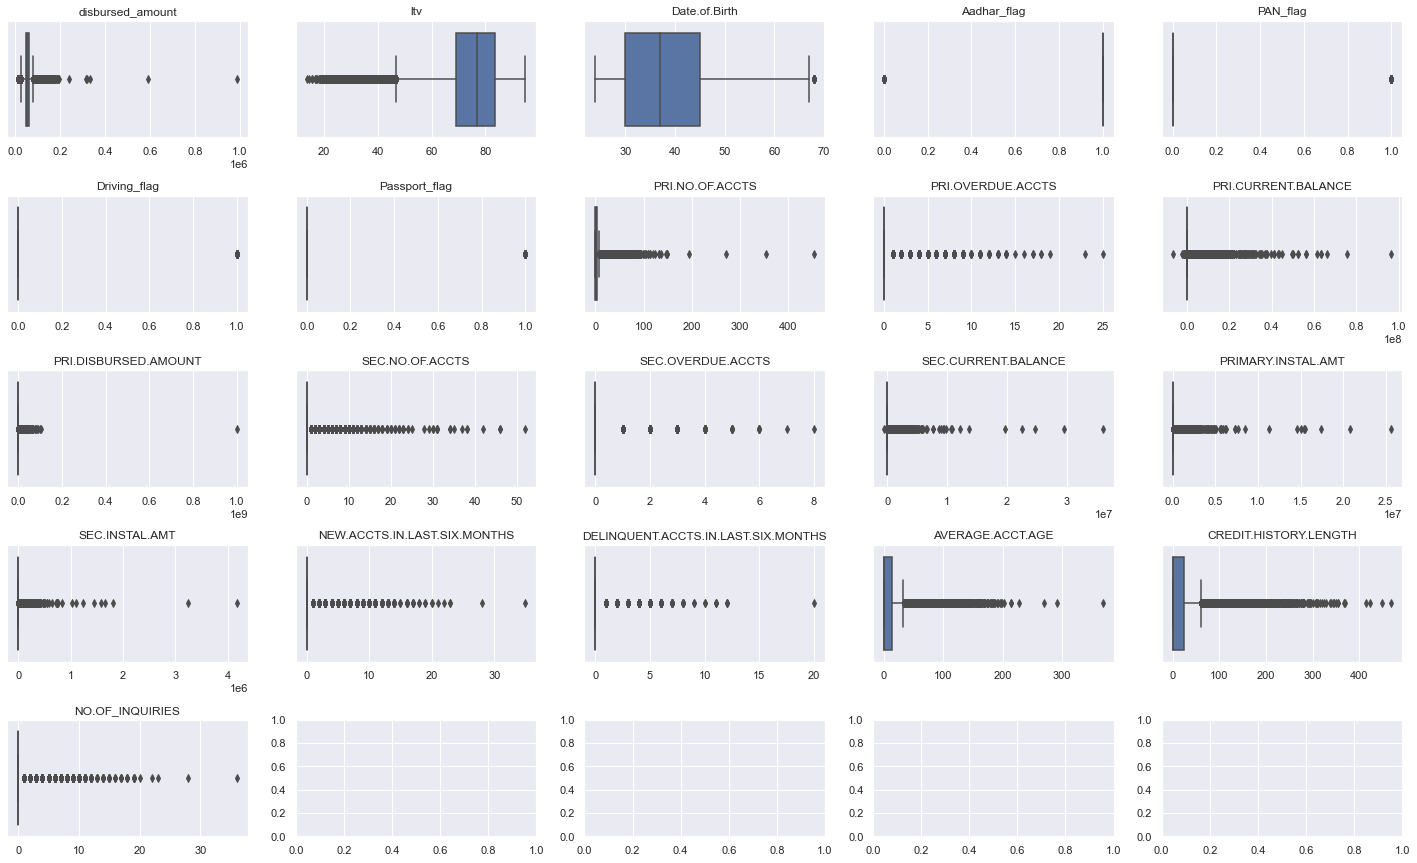

In [162]:
df_numeric = df[df.select_dtypes(["int64","float64"]).columns]

plt.rc("figure",figsize=(25,15))

fig, ax = plt.subplots(nrows=5,ncols=5)

fig.subplots_adjust(hspace=0.5)

for ax, feature, name in zip(ax.flatten(), df_numeric.values.T, df_numeric.columns):
    sns.boxplot(x=feature,ax=ax)
    ax.set(title=str(name))
plt.show()

### Making pipelines and models

In [163]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures,PowerTransformer,RobustScaler
from sklearn.compose import ColumnTransformer

In [164]:
X = df.iloc[:,:-1]
y= df.iloc[:,-1]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [165]:
categorical_columns = df.select_dtypes(include="object").columns

In [166]:
categorical_columns = categorical_columns[:-1]

In [167]:
categorical_columns

Index(['branch_id', 'supplier_id', 'manufacturer_id', 'Employment.Type',
       'State_ID', 'Employee_code_ID', 'PERFORM_CNS.SCORE.DESCRIPTION'],
      dtype='object')

In [168]:
numeric_columns = df.select_dtypes(exclude="object").columns

In [169]:
numeric_columns = list(numeric_columns[:2])+list(numeric_columns[8:])

In [170]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

Before you continue reading, I want to point out that i tried every model with both preprocessing pipelines, results were basically the same(or worse), so i left the basic preprocessing pipeline on almost all models.

I also tried mixing poly features with robust/power transformation which didn't make a lot of difference so i kept only the power transformation.

In [171]:
categorical_prep = Pipeline(steps=[
    ("onehot",OneHotEncoder(handle_unknown="ignore"))
])

numerical_prep= Pipeline(steps=[
    # ("robust",RobustScaler()),
    ("power",PowerTransformer(method="yeo-johnson"))
    #("poly",PolynomialFeatures(degree=2))
])

preprocessorpoly =  ColumnTransformer(transformers=[
    ("cat",categorical_prep,categorical_columns),
    ("num",numerical_prep,numeric_columns)
])

In [172]:
preprocessor =  ColumnTransformer(transformers=[
    ("cat",categorical_prep,categorical_columns)
])

In [173]:
tree = DecisionTreeClassifier()

pipeline_tree = Pipeline(steps=[
    ("prepro",preprocessor),
    ("dt",tree)
])


In [174]:
# params = {"dt__min_samples_split": range(2,30,2),"dt__min_samples_leaf": range(20,100,5)}

# n_iter_search = 50

# random_search = RandomizedSearchCV(pipeline_tree, param_distributions=params,n_iter=n_iter_search, cv=5, scoring='accuracy',n_jobs=-1)

# random_search.fit(X_train,y_train)

# print('Best param: ',random_search.best_params_)

In [175]:
tree = DecisionTreeClassifier(min_samples_split= 6, min_samples_leaf= 95)

pipeline_tree = Pipeline(steps=[
    ("prepro",preprocessor),
    ("dt",tree)
])

In [176]:
resultdt = cross_validate(pipeline_tree, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [177]:
print(f'Accuracy: {resultdt["test_Accuracy"].mean()}')
print(f'AUC: {resultdt["test_AUC"].mean()}')

Accuracy: 0.783224499305986
AUC: 0.5994225893059474


In [178]:
lr = LogisticRegression()

pipeline_lr = Pipeline(steps=[
    ("prepro",preprocessor),
    ("lr",lr)
])


In [179]:
# params = {"lr__penalty": ["l1","l2"],"lr__C": np.linspace(0.005,1,100)}

# n_iter_search = 50

# random_search = RandomizedSearchCV(pipeline_lr, param_distributions=params,n_iter=n_iter_search, cv=5, scoring='accuracy',n_jobs=-1)

# random_search.fit(X_train,y_train)

# print('Best param: ',random_search.best_params_)

In [180]:
lr = LogisticRegression(C=0.035)

pipeline_lr = Pipeline(steps=[
    ("prepro",preprocessor),
    ("lr",lr)
])

In [181]:
resultlr = cross_validate(pipeline_lr, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [182]:
print(f'Accuracy: {resultlr["test_Accuracy"].mean()}')
print(f'AUC: {resultlr["test_AUC"].mean()}')

Accuracy: 0.7832189554541433
AUC: 0.6194142522346263


In [183]:
nb = MultinomialNB()

pipeline_nb = Pipeline(steps=[
    ("prepro",preprocessor),
    ("nb",nb)
])

In [184]:
resultnb = cross_validate(pipeline_nb, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [185]:
print(f'Accuracy: {resultnb["test_Accuracy"].mean()}')
print(f'AUC: {resultnb["test_AUC"].mean()}')

Accuracy: 0.7388937712511343
AUC: 0.6107845399632588


In [186]:
from sklearn.ensemble import RandomForestClassifier

In [187]:
rf = RandomForestClassifier(n_estimators=50,n_jobs=-1)

pipeline_rf = Pipeline(steps=[
    ("prepro",preprocessor),
    ("rf",rf)
])

In [188]:
resultrf = cross_validate(pipeline_rf, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [189]:
print(f'Accuracy: {resultrf["test_Accuracy"].mean()}')
print(f'AUC: {resultrf["test_AUC"].mean()}')

Accuracy: 0.7501136438923203
AUC: 0.5690628595592095


#### Oversampling

In [190]:
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline

In [191]:
treeos = DecisionTreeClassifier()

pipeline_treeos = imbpipeline(steps=[
    ("prepro",preprocessor),
    ("smote",SMOTE(n_jobs=-1)),
    ("dt",treeos)
])

In [192]:
resultdtos = cross_validate(pipeline_treeos, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [193]:
print(f'Accuracy: {resultdtos["test_Accuracy"].mean()}')
print(f'AUC: {resultdtos["test_AUC"].mean()}')

Accuracy: 0.6926893369720214
AUC: 0.5443615452210595


In [194]:
lros = LogisticRegression()

pipeline_lros = imbpipeline(steps=[
    ("prepro",preprocessor),
    ("smote",SMOTE(n_jobs=-1)),
    ("lr",lros)
])

In [195]:
resultlros = cross_validate(pipeline_lros, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [196]:
print(f'Accuracy: {resultlros["test_Accuracy"].mean()}')
print(f'AUC: {resultlros["test_AUC"].mean()}')

Accuracy: 0.5862722655443235
AUC: 0.6007024068383784


In [197]:
nbos = MultinomialNB()

pipeline_nbos = imbpipeline(steps=[
    ("prepro",preprocessor),
    ("smote",SMOTE(n_jobs=-1)),
    ("nb",nbos)
])

In [198]:
resultnbos = cross_validate(pipeline_nbos, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [199]:
print(f'Accuracy: {resultnbos["test_Accuracy"].mean()}')
print(f'AUC: {resultnbos["test_AUC"].mean()}')

Accuracy: 0.5983901831823646
AUC: 0.6075855352819703


In [200]:
rfos = RandomForestClassifier(n_estimators=50,n_jobs=-1)

pipeline_rfos = imbpipeline(steps=[
    ("prepro",preprocessor),
    ("smote",SMOTE(n_jobs=-1)),
    ("rf",rfos)
])

In [201]:
resultrfos = cross_validate(pipeline_rfos, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [202]:
print(f'Accuracy: {resultrfos["test_Accuracy"].mean()}')
print(f'AUC: {resultrfos["test_AUC"].mean()}')

Accuracy: 0.6948512701754949
AUC: 0.5700245142648095


#### Undersampling

In [203]:
treeus = DecisionTreeClassifier()

pipeline_treeus = imbpipeline(steps=[
    ("prepro",preprocessor),
    ("smote",SMOTE(sampling_strategy=0.3,n_jobs=-1)),
    ("undersmpl",RandomUnderSampler(sampling_strategy=0.5)),
    ("dt",treeus)
])

In [204]:
resultdtus = cross_validate(pipeline_treeus, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [205]:
print(f'Accuracy: {resultdtus["test_Accuracy"].mean()}')
print(f'AUC: {resultdtus["test_AUC"].mean()}')

Accuracy: 0.6958768174650758
AUC: 0.5463247267791151


In [206]:
lrus = LogisticRegression()

pipeline_lrus = imbpipeline(steps=[
    ("prepro",preprocessor),
    ("smote",SMOTE(sampling_strategy=0.3,n_jobs=-1)),
    ("undersmpl",RandomUnderSampler(sampling_strategy=0.5)),
    ("lr",lrus)
])

In [207]:
resultlrus = cross_validate(pipeline_lrus, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [208]:
print(f'Accuracy: {resultlrus["test_Accuracy"].mean()}')
print(f'AUC: {resultlrus["test_AUC"].mean()}')

Accuracy: 0.7482621316671005
AUC: 0.6061765182488806


In [209]:
nbus = MultinomialNB()

pipeline_nbus = imbpipeline(steps=[
    ("prepro",preprocessor),
    ("smote",SMOTE(sampling_strategy=0.3,n_jobs=-1)),
    ("undersmpl",RandomUnderSampler(sampling_strategy=0.5)),
    ("nb",nbus)
])

In [210]:
resultnbus = cross_validate(pipeline_nbus, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [211]:
print(f'Accuracy: {resultnbus["test_Accuracy"].mean()}')
print(f'AUC: {resultnbus["test_AUC"].mean()}')

Accuracy: 0.6868410405281199
AUC: 0.6088365095688564


In [212]:
rfus = RandomForestClassifier(n_estimators=50,n_jobs=-1)

pipeline_rfus = imbpipeline(steps=[
    ("prepro",preprocessor),
    ("smote",SMOTE(sampling_strategy=0.3,n_jobs=-1)),
    ("undersmpl",RandomUnderSampler(sampling_strategy=0.5)),
    ("rf",rfus)
])

In [213]:
resultrfus = cross_validate(pipeline_rfus, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [214]:
print(f'Accuracy: {resultrfus["test_Accuracy"].mean()}')
print(f'AUC: {resultrfus["test_AUC"].mean()}')

Accuracy: 0.7091089468388397
AUC: 0.5722000908282731


#### Ensamble

In [215]:
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

In [216]:
lr = LogisticRegression(C=0.035)

bagginglr = BaggingClassifier(lr,n_jobs=-1)

pipeline_bagginglr = Pipeline(steps=[
    ("prepro",preprocessor),
    ("bagginglr",bagginglr)
])

In [217]:
resultbagginglr = cross_validate(pipeline_bagginglr, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [218]:
print(f'Accuracy: {resultbagginglr["test_Accuracy"].mean()}')
print(f'AUC: {resultbagginglr["test_AUC"].mean()}')

Accuracy: 0.7832023252814666
AUC: 0.6185103552338539


In [219]:
dt = DecisionTreeClassifier(min_samples_split= 6, min_samples_leaf= 95)

baggingdt = BaggingClassifier(dt,n_jobs=-1)

pipeline_baggingdt = Pipeline(steps=[
    ("prepro",preprocessor),
    ("baggingdt",baggingdt)
])

In [220]:
resultbaggingdt = cross_validate(pipeline_baggingdt, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [221]:
print(f'Accuracy: {resultbaggingdt["test_Accuracy"].mean()}')
print(f'AUC: {resultbaggingdt["test_AUC"].mean()}')

Accuracy: 0.7831302616608184
AUC: 0.6055857487661238


In [249]:
xgboost = xgb.XGBClassifier(booster="gbtree",n_estimators = 50)

pipeline_xg = Pipeline(steps=[
    ("prepro",preprocessorpoly),
    ("xg",xgboost)
])

In [223]:
# params = {"xg__learning_rate": np.linspace(0.1,1,10),"xg__max_depth": range(10,50,5),"xg__min_split_loss": range(0,50,5)}

# n_iter_search = 50

# random_search = RandomizedSearchCV(pipeline_xg, param_distributions=params,n_iter=n_iter_search, cv=5, scoring='accuracy',n_jobs=-1)

# random_search.fit(X_train,y_train)

# print('Best param: ',random_search.best_params_)

# #Best param:  {'xg__min_split_loss': 30, 'xg__max_depth': 40, 'xg__learning_rate': 0.8}

In [250]:
resultxg = cross_validate(pipeline_xg, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

[13:29:32] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:29:38] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:29:44] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:29:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

In [251]:
print(f'Accuracy: {resultxg["test_Accuracy"].mean()}')
print(f'AUC: {resultxg["test_AUC"].mean()}')

Accuracy: 0.7834628668045028
AUC: 0.6538901046824186


In [226]:
lr = LogisticRegression(C=0.035)

adalr = AdaBoostClassifier(lr)

pipeline_adalr = Pipeline(steps=[
    ("prepro",preprocessor),
    ("adalr",adalr)
])

In [227]:
resultadalr = cross_validate(pipeline_adalr, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [228]:
print(f'Accuracy: {resultadalr["test_Accuracy"].mean()}')
print(f'AUC: {resultadalr["test_AUC"].mean()}')

Accuracy: 0.7828420014931693
AUC: 0.5657511912351385


In [229]:
lgbm = LGBMClassifier(n_estimators=100, n_jobs=-1)

pipeline_lgbm = Pipeline(steps=[
    ("prepro",preprocessorpoly),
    ("lgbm",lgbm)
])

In [230]:
resultlgbm = cross_validate(pipeline_lgbm, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

In [231]:
print(f'Accuracy: {resultlgbm["test_Accuracy"].mean()}')
print(f'AUC: {resultlgbm["test_AUC"].mean()}')

Accuracy: 0.7837400380392652
AUC: 0.6591715987076466


In [232]:
pipeline_xgos = imbpipeline(steps=[
    ("prepro",preprocessorpoly),
    ("smote",SMOTE(n_jobs=-1)),
    ("xg",xgboost)
])

pipeline_xgus = imbpipeline(steps=[
    ("prepro",preprocessorpoly),
    ("smote",SMOTE(sampling_strategy=0.3,n_jobs=-1)),
    ("undersmpl",RandomUnderSampler(sampling_strategy=0.5)),
    ("xg",xgboost)
])

In [233]:
resultxgos = cross_validate(pipeline_xgos, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

[11:28:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:58] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:29:54] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:30:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

In [234]:
print(f'Accuracy: {resultxgos["test_Accuracy"].mean()}')
print(f'AUC: {resultxgos["test_AUC"].mean()}')

Accuracy: 0.6914309712598722
AUC: 0.6077770410011938


In [235]:
resultxgus = cross_validate(pipeline_xgus, X_train, y_train, cv=5, scoring={'Accuracy':'accuracy', 'AUC':'roc_auc'})

[11:32:40] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:29] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:34:20] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:35:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

In [236]:
print(f'Accuracy: {resultxgus["test_Accuracy"].mean()}')
print(f'AUC: {resultxgus["test_AUC"].mean()}')

Accuracy: 0.7738505738344535
AUC: 0.6524020207732144


### Final results on the test data set

In [252]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score

In [253]:
pipeline_lr.fit(X_train,y_train)

y_hat = pipeline_lr.predict(X_test)

print(f'Accuracy {accuracy_score(y_test, y_hat)}')
lr_auc = roc_auc_score(y_test, pipeline_lr.predict_proba(X_test)[:, 1])
print('AUC: ', lr_auc)
print(confusion_matrix(y_test, y_hat))

Accuracy 0.7827002816026963
AUC:  0.6207938921872068
[[35235    71]
 [ 9729    64]]


In [254]:
pipeline_xg.fit(X_train,y_train)

y_hat = pipeline_xg.predict(X_test)

print(f'Accuracy {accuracy_score(y_test, y_hat)}')
xg_auc = roc_auc_score(y_test, pipeline_xg.predict_proba(X_test)[:, 1])
print('AUC: ', xg_auc)
print(confusion_matrix(y_test, y_hat))

[13:31:34] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy 0.7831659238564048
AUC:  0.6570205514386861
[[35162   144]
 [ 9635   158]]


In [255]:
pipeline_lgbm.fit(X_train,y_train)

y_hat = pipeline_lgbm.predict(X_test)

print(f'Accuracy {accuracy_score(y_test, y_hat)}')
lgbm_auc = roc_auc_score(y_test, pipeline_lgbm.predict_proba(X_test)[:, 1])
print('AUC: ', lgbm_auc)
print(confusion_matrix(y_test, y_hat))

Accuracy 0.783343311381627
AUC:  0.6618629403651335
[[35176   130]
 [ 9641   152]]


In [256]:
def compute_eval_metrics(y, y_hat, pos_label):
    return {'Accuracy': accuracy_score(y, y_hat), 'Precision': precision_score(y, y_hat, pos_label = pos_label), 'Recall': recall_score(y, y_hat, pos_label = pos_label), 'F1': f1_score(y, y_hat, pos_label=pos_label)}

In [257]:
dflr = pd.DataFrame({metric: [score] for metric, score in compute_eval_metrics(y_test, pipeline_lr.predict(X_test), 'Yes').items()}, index=['Logistic regression'])
dfxg = pd.DataFrame({metric: [score] for metric, score in compute_eval_metrics(y_test, pipeline_xg.predict(X_test), 'Yes').items()}, index=['XGBoost'])
dflgbm = pd.DataFrame({metric: [score] for metric, score in compute_eval_metrics(y_test, pipeline_lgbm.predict(X_test), 'Yes').items()}, index=['LGBM'])
pd.concat([dflr, dfxg,dflgbm])

,Accuracy,Precision,Recall,F1
Logistic regression,0.782700,0.474074,0.006535,0.012893
XGBoost,0.783166,0.523179,0.016134,0.031303
LGBM,0.783343,0.539007,0.015521,0.030174


#### Threshold

In [258]:
probs = pipeline_lr.predict_proba(X_test)
threshold = 0.7
prediction = np.array(['No' if x > threshold else 'Yes' for x in probs[:, 0]])
print(accuracy_score(y_test, prediction))
print(roc_auc_score(y_test, probs[:, 1]))
print(confusion_matrix(y_test, prediction))

0.744473269917293
0.6207938921872068
[[31581  3725]
 [ 7799  1994]]


In [259]:
probs = pipeline_xg.predict_proba(X_test)
threshold = 0.7
prediction = np.array(['No' if x > threshold else 'Yes' for x in probs[:, 0]])
print(accuracy_score(y_test, prediction))
print(roc_auc_score(y_test, probs[:, 1]))
print(confusion_matrix(y_test, prediction))

0.7416572429543893
0.6570205514386861
[[30797  4509]
 [ 7142  2651]]


In [260]:
probs = pipeline_lgbm.predict_proba(X_test)
threshold = 0.7
prediction = np.array(['No' if x > threshold else 'Yes' for x in probs[:, 0]])
print(accuracy_score(y_test, prediction))
print(roc_auc_score(y_test, probs[:, 1]))
print(confusion_matrix(y_test, prediction))

0.7348943435552895
0.6618629403651335
[[30157  5149]
 [ 6807  2986]]
